![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)


## <a id='part0'>Part 0: Set Up and Import</a>
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

In [2]:
#Libraries
import pandas as pd
import numpy as np
import os
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C, RationalQuadratic, ExpSineSquared, RBF, Sum, Product, WhiteKernel, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import precision_score, explained_variance_score, accuracy_score, classification_report, roc_auc_score, accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from panelsplit import PanelSplit
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels for statistical methods
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import het_arch
import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# # scipy stats for shapiro test
# from scipy import stats
# from pmdarima.arima import auto_arima
# from arch import arch_model

#Paths
path_in_ = r'/Users/amberwalker/SP500-Prediction-NN-GP/data'

## <a id='part3'>Part 3: Modeling</a>
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - (I think we should predict a binary outcome of the stock direction goes up or down personally)
  - Feature creation: Create multiple types of lag variables for different lag amounts.
  - Feature selection: (I'd suggest a good old random forest cause I personally love a random forest feature selection or an XGBoost feature selection).
  - Create a neural network, discuss hyper parameter tuning.
  - Create a gaussian process, discuss hyper parameter tuning.

Class to evaluate metrics

In [3]:
class RegressionMetrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name):
        # Calculate regression metrics
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

        # Store results
        self.results[method_name] = {
            'MSE': mse,
            'MAE': mae
        }
    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, figsize=(15, 10))

        # Plot each metric
        metrics = ['MSE', 'MAE']
        for i, metric in enumerate(metrics):
            ax = axs[i]  # Use a single index to access subplots in a 1D array
            values = [res[metric] for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + v * 0.05, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

class ClassificationMetrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()



### Load and Preprocess Data

In [4]:
sp500_data = pd.read_csv(path_in_ + '/goyal-welch2022Monthly.csv', sep=',')
sp500_data.columns = sp500_data.columns.str.lower().str.strip()
sp500_data['date'] = pd.to_datetime(sp500_data['yyyymm'], format='%Y%m')
sp500_data['year'] = sp500_data['date'].dt.year
sp500_data['month'] = sp500_data['date'].dt.month
sp500_data = sp500_data.rename(columns={'yyyymm': 'period'})
sp500_data['index'] = sp500_data['index'].astype(str).str.replace(',', '').astype(float)
sp500_df = sp500_data[sp500_data['date'] >= '1926-01']

sp500_df.head()

,period,index,d12,e12,b/m,tbl,aaa,baa,lty,ntis,...,infl,ltr,corpr,svar,csp,crsp_spvw,crsp_spvwx,date,year,month
660,192601,12.74,0.6075,1.249,0.387671,0.0349,0.0482,0.0609,0.0374,NaN,...,0.000000,0.0138,0.0072,0.000857,NaN,-0.001783,-0.003980,1926-01-01,1926,1
661,192602,12.18,0.6150,1.248,0.394363,0.0318,0.0477,0.0602,0.0372,NaN,...,0.000000,0.0063,0.0045,0.001099,NaN,-0.033296,-0.037876,1926-02-01,1926,2
662,192603,11.46,0.6225,1.248,0.494091,0.0314,0.0479,0.0605,0.0371,NaN,...,-0.005587,0.0041,0.0084,0.006016,NaN,-0.057708,-0.062007,1926-03-01,1926,3
663,192604,11.72,0.6300,1.247,0.482917,0.0308,0.0474,0.0598,0.0368,NaN,...,0.005618,0.0076,0.0097,0.001466,NaN,0.038522,0.034856,1926-04-01,1926,4
664,192605,11.81,0.6375,1.246,0.483860,0.0317,0.0471,0.0586,0.0369,NaN,...,-0.005587,0.0014,0.0044,0.000690,NaN,0.013623,0.009070,1926-05-01,1926,5


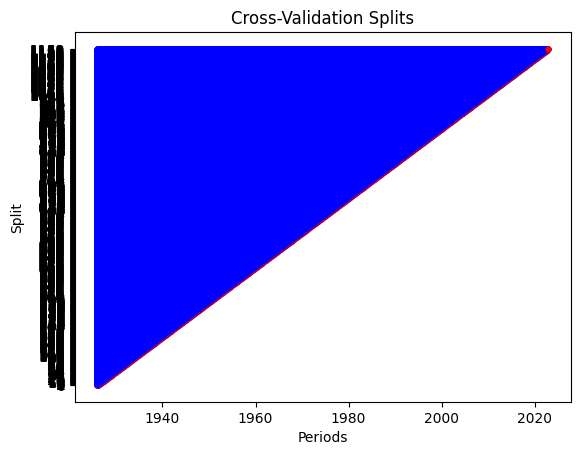

ValueError: setting an array element with a sequence.

In [57]:
#impute csp missing values using PanelSplit and KNN
sp500_df = sp500_df.sort_values('date')
features = ['csp', 'ntis']
n_splits = len(pd.date_range(start=sp500_df['date'].min(), end=sp500_df['date'].max(), freq='ME')) - 1  # minus 1 because the first period is only used for training
panel_split = PanelSplit(periods=sp500_df['date'], n_splits=n_splits, gap=0, test_size=1, plot=True)
imputed_data, fitted_imputers = panel_split.cross_val_fit_transform(KNNImputer(), sp500_df[features], include_test_in_fit=True)
sp500_df[features] = imputed_data

print(sp500_df.head())


In [60]:
print(sp500_df[features].info())
print(sp500_df[features].head())


<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 660 to 1823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   csp     788 non-null    float64
 1   ntis    1153 non-null   float64
dtypes: float64(2)
memory usage: 27.3 KB
None
     csp  ntis
660  NaN   NaN
661  NaN   NaN
662  NaN   NaN
663  NaN   NaN
664  NaN   NaN


In [59]:
print("Shape of imputed_data:", imputed_data.shape)
print("Shape of sp500_df[features]:", sp500_df[features].shape)


NameError: name 'imputed_data' is not defined

In [ ]:
print(sp500_df[features].isnull().sum())

csp     376
ntis     11
dtype: int64


### Feature engineering

#### Financial Indicators
Compute the indicators (code borrowed from PythonLab3_2_GWcausalSP500)

In [ ]:
sp500_df['index'] = pd.to_numeric(sp500_df['index'], errors='coerce')
sp500_df['d12'] = pd.to_numeric(sp500_df['d12'], errors='coerce')
sp500_df['rfree'] = pd.to_numeric(sp500_df['rfree'], errors='coerce')

print(sp500_df.dtypes)

sp500_df['logret'] = np.log(sp500_df['index']).diff() #log return of sp500

sp500_df['logindex'] = np.log(sp500_df['index']) #log of index

sp500_df['index_return'] = sp500_df['index'].pct_change()  #percentage change
sp500_df['direction'] = (sp500_df['index_return'] > 0).astype(int) #direction

print(sp500_df[['date', 'logindex', 'logret', 'direction']].head())

#lags for dp
sp500_df['dp_lag1'] = sp500_df['dp'].shift(1)
sp500_df['dp_lag2'] = sp500_df['dp'].shift(2)
sp500_df['dp_lag3'] = sp500_df['dp'].shift(3)
sp500_df['dp_lag4'] = sp500_df['dp'].shift(4)

#lags for svar
sp500_df['svar_lag1'] = sp500_df['svar'].shift(1)
sp500_df['svar_lag2'] = sp500_df['svar'].shift(2)
sp500_df['svar_lag3'] = sp500_df['svar'].shift(3)
sp500_df['svar_lag4'] = sp500_df['svar'].shift(4)

#lags for bm
sp500_df['bm_lag1'] = sp500_df['bm'].shift(1)
sp500_df['bm_lag2'] = sp500_df['bm'].shift(2)
sp500_df['bm_lag3'] = sp500_df['bm'].shift(3)
sp500_df['bm_lag4'] = sp500_df['bm'].shift(4)

#lags for target: log of price
sp500_df['logindex_lag1'] = sp500_df['logindex'].shift(1)
sp500_df['logindex_lag2'] = sp500_df['logindex'].shift(2)
sp500_df['logindex_lag3'] = sp500_df['logindex'].shift(3)
sp500_df['logindex_lag4'] = sp500_df['logindex'].shift(4)

#lags for target: log of return
sp500_df['logret_lag1'] = sp500_df['logret'].shift(1)
sp500_df['logret_lag2'] = sp500_df['logret'].shift(2)
sp500_df['logret_lag3'] = sp500_df['logret'].shift(3)
sp500_df['logret_lag4'] = sp500_df['logret'].shift(4)

#lags for target: direction
sp500_df['direction_lag1'] = sp500_df['direction'].shift(1)
sp500_df['direction_lag2'] = sp500_df['direction'].shift(2)
sp500_df['direction_lag3'] = sp500_df['direction'].shift(3)
sp500_df['direction_lag4'] = sp500_df['direction'].shift(4)

sp500_df.head()

period                 int64
index                float64
d12                  float64
e12                  float64
b/m                  float64
tbl                  float64
aaa                  float64
baa                  float64
lty                  float64
ntis                 float64
rfree                float64
infl                 float64
ltr                  float64
corpr                float64
svar                 float64
csp                  float64
crsp_spvw            float64
crsp_spvwx           float64
date          datetime64[ns]
year                   int32
month                  int32
dtype: object


      period    index      d12       e12        bm     tbl     aaa     baa  \
660   192601    12.74   0.6075    1.2490  0.387671  0.0349  0.0482  0.0609   
661   192602    12.18   0.6150    1.2480  0.394363  0.0318  0.0477  0.0602   
662   192603    11.46   0.6225    1.2480  0.494091  0.0314  0.0479  0.0605   
663   192604    11.72   0.6300    1.2470  0.482917  0.0308  0.0474  0.0598   
664   192605    11.81   0.6375    1.2460  0.483860  0.0317  0.0471  0.0586   
...      ...      ...      ...       ...       ...     ...     ...     ...   
1819  202208  3955.00  64.8854  188.8067  0.227429  0.0263  0.0407  0.0515   
1820  202209  3585.62  65.3183  187.0800  0.249478  0.0313  0.0459  0.0569   
1821  202210  3871.98  65.8531  182.3033  0.218935  0.0372  0.0510  0.0626   
1822  202211  4080.11  66.3880  177.5267  0.207182  0.0415  0.0490  0.0607   
1823  202212  3839.50  66.9228  172.7500  0.216199  0.0425  0.0443  0.0559   

         lty      ntis  ...     ltr   corpr      svar       csp

#### Create Target Variables

          date  logindex    logret  direction
660 1926-01-01  2.544747       NaN          0
661 1926-02-01  2.499795 -0.044951          0
662 1926-03-01  2.438863 -0.060933          0
663 1926-04-01  2.461297  0.022434          1
664 1926-05-01  2.468947  0.007650          1


#### Create Lag Variables

,period,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,logindex_lag3,logindex_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,direction_lag1,direction_lag2,direction_lag3,direction_lag4
660,192601,12.74,0.6075,1.249,0.387671,0.0349,0.0482,0.0609,0.0374,0.015959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,192602,12.18,0.6150,1.248,0.394363,0.0318,0.0477,0.0602,0.0372,0.015959,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
662,192603,11.46,0.6225,1.248,0.494091,0.0314,0.0479,0.0605,0.0371,0.015959,...,NaN,NaN,-0.044951,NaN,NaN,NaN,0.0,0.0,NaN,NaN
663,192604,11.72,0.6300,1.247,0.482917,0.0308,0.0474,0.0598,0.0368,0.015959,...,2.544747,NaN,-0.060933,-0.044951,NaN,NaN,0.0,0.0,0.0,NaN
664,192605,11.81,0.6375,1.246,0.483860,0.0317,0.0471,0.0586,0.0369,0.015959,...,2.499795,2.544747,0.022434,-0.060933,-0.044951,NaN,1.0,0.0,0.0,0.0


In [28]:
#check for missing values
sp500_df_filtered = sp500_df[sp500_df['date'] >= '1927-01-01']
sp500_nulls = sp500_df_filtered.isna().sum()
print(sp500_nulls)

#save data
sp500_df_filtered.to_csv(path_in_ + 'sp500_clean.csv', index=False)

period            0
index             0
d12               0
e12               0
bm                0
tbl               0
aaa               0
baa               0
lty               0
ntis              0
rfree             0
infl              0
ltr               0
corpr             0
svar              0
csp               0
crsp_spvw         0
crsp_spvwx        0
date              0
year              0
month             0
dp                0
logret            0
logindex          0
index_return      0
direction         0
dp_lag1           0
dp_lag2           0
dp_lag3           0
dp_lag4           0
svar_lag1         0
svar_lag2         0
svar_lag3         0
svar_lag4         0
bm_lag1           0
bm_lag2           0
bm_lag3           0
bm_lag4           0
logindex_lag1     0
logindex_lag2     0
logindex_lag3     0
logindex_lag4     0
logret_lag1       0
logret_lag2       0
logret_lag3       0
logret_lag4       0
direction_lag1    0
direction_lag2    0
direction_lag3    0
direction_lag4    0


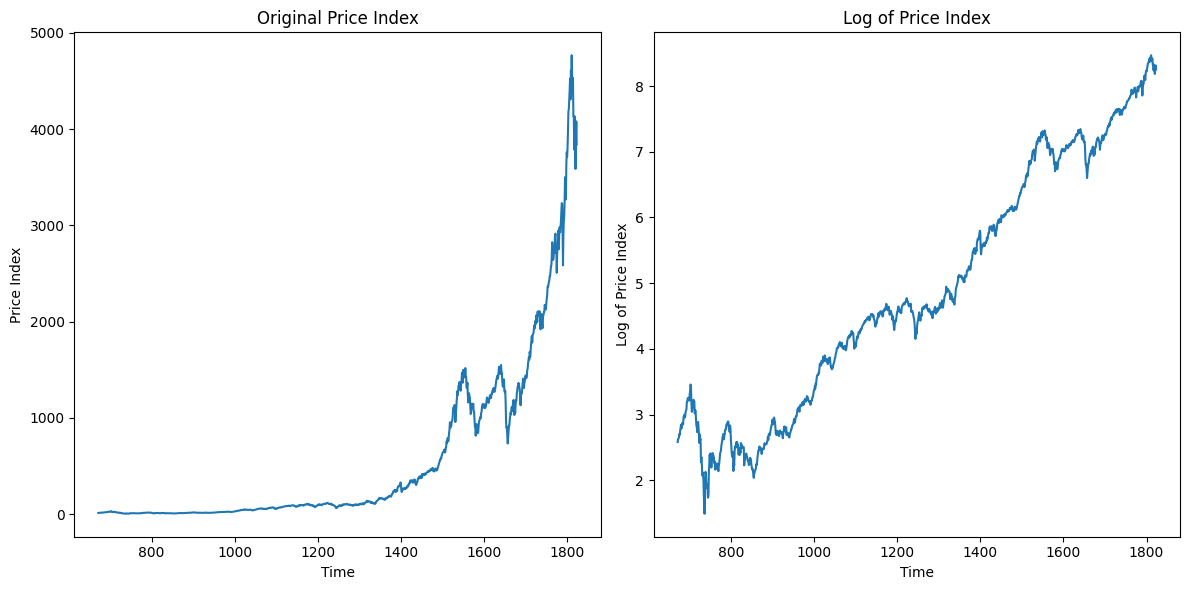

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sp500_df_filtered['index'])
plt.title('Original Price Index')
plt.xlabel('Time')
plt.ylabel('Price Index')

plt.subplot(122)
plt.plot(sp500_df_filtered['logindex'])
plt.title('Log of Price Index')
plt.xlabel('Time')
plt.ylabel('Log of Price Index')

plt.tight_layout()
plt.show()


### Feature selection: Random Forest

In [30]:
#load the clean data
sp500_df_filtered = pd.read_csv(path_in_ + 'sp500_clean.csv')

In [32]:
features = ['dp', 'svar', 'bm','dp_lag1', 'dp_lag2',
       'dp_lag3', 'dp_lag4', 'svar_lag1', 'svar_lag2', 'svar_lag3',
       'svar_lag4', 'bm_lag1', 'bm_lag2', 'bm_lag3', 'bm_lag4',
        'logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4',
       'direction_lag1', 'direction_lag2', 'direction_lag3', 'direction_lag4']

#prepare the data
train_data = sp500_df_filtered[sp500_df_filtered['date'] < '2018-01-01']
test_data = sp500_df_filtered[(sp500_df_filtered['date'] >= '2018-01-01') & (sp500_df_filtered['date'] <= '2021-12-31')]

X_train = train_data[features]
Y_train = {
    'logindex': train_data['logindex'],
    'logret': train_data['logret'],
    'direction': train_data['direction']
}

# since direction is binary, we define the model types for each target type
model_types = {
    'logret': RandomForestRegressor,
    'logindex': RandomForestRegressor,
    'direction': RandomForestClassifier
}

n_estimators = 100
top_n = 15
feature_importances = {}
top_features = {}

for target, y_train in Y_train.items():
    valid_idx = y_train.notna()
    model = model_types[target](n_estimators=n_estimators, random_state=42)
    model.fit(X_train[valid_idx], y_train[valid_idx])

    # Store and sort feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_importances[target] = importances
    top_features[target] = X_train.columns[indices[:top_n]]

    print(f"Top {top_n} important features for {target}:", top_features[target])

Top 15 important features for logindex: Index(['logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'bm', 'dp', 'dp_lag1', 'svar', 'bm_lag1', 'bm_lag3', 'bm_lag2',
       'bm_lag4', 'dp_lag2', 'svar_lag2', 'dp_lag3'],
      dtype='object')
Top 15 important features for logret: Index(['svar', 'bm_lag2', 'dp', 'svar_lag1', 'logret_lag3', 'svar_lag2',
       'logret_lag2', 'logret_lag1', 'logret_lag4', 'svar_lag3', 'svar_lag4',
       'bm', 'dp_lag1', 'bm_lag1', 'dp_lag2'],
      dtype='object')
Top 15 important features for direction: Index(['svar', 'dp', 'bm', 'logret_lag1', 'svar_lag1', 'dp_lag1',
       'logret_lag2', 'svar_lag2', 'bm_lag1', 'logret_lag3', 'svar_lag4',
       'logret_lag4', 'svar_lag3', 'dp_lag2', 'bm_lag2'],
      dtype='object')


### Model 1: Gaussian Process

#### GridSearch CV & Prediction -Continuous Targets



In [34]:
targets = ['logindex', 'logret']

sp500_df_filtered['date'] = pd.to_datetime(sp500_df_filtered['date'])
train_data = sp500_df_filtered[sp500_df_filtered['date'] < '2018-01-01']
#test_data = sp500_df_filtered[(sp500_df_filtered['date'] >= '2018-01-01') & (sp500_df_filtered['date'] <= '2021-12-31')]

In [35]:
top_features_cont = {key: top_features[key] for key in targets}

print(top_features_cont)

{'logindex': Index(['logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'bm', 'dp', 'dp_lag1', 'svar', 'bm_lag1', 'bm_lag3', 'bm_lag2',
       'bm_lag4', 'dp_lag2', 'svar_lag2', 'dp_lag3'],
      dtype='object'), 'logret': Index(['svar', 'bm_lag2', 'dp', 'svar_lag1', 'logret_lag3', 'svar_lag2',
       'logret_lag2', 'logret_lag1', 'logret_lag4', 'svar_lag3', 'svar_lag4',
       'bm', 'dp_lag1', 'bm_lag1', 'dp_lag2'],
      dtype='object')}


In [62]:
models = {}
pred_gp = {}
# performance_metrics = {}

# TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop through each target variable
for target, features in top_features_cont.items():
    X = train_data[features]
    y = train_data[target]

    kernel_options = [
        ConstantKernel(1.0) * RBF(length_scale=1) + WhiteKernel(noise_level=0.5),
        ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5),
        RationalQuadratic(length_scale=1.0, alpha=1.5),
        DotProduct(sigma_0=1)
    ]

    param_grid = {
        'kernel': kernel_options,
        'alpha': [1e-4]
    }

    # Prepare a list for predictions
    predictions = []
    performance_metrics = []

    for train_idx, test_idx in tscv.split(X):
        # Split the data
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # Scale data fold-by-fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_test_scaled = scaler.transform(X_test_fold)

        # GridSearch for Gaussian Process
        gp = GaussianProcessRegressor(normalize_y=True, random_state=0, n_restarts_optimizer=30)
        grid_search = GridSearchCV(gp, param_grid, scoring='neg_mean_squared_error', cv=3)
        grid_search.fit(X_train_scaled, y_train_fold)

        # Evaluate on test fold
        y_pred = grid_search.best_estimator_.predict(X_test_scaled)
        mse = mean_squared_error(y_test_fold, y_pred)
        mae = mean_absolute_error(y_test_fold, y_pred)
        r2 = r2_score(y_test_fold, y_pred)

        performance_metrics.append({'MSE': mse, 'MAE': mae, 'R2': r2})

    print(f"Performance for {target}: {performance_metrics}")


/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

Performance for logindex: [{'MSE': np.float64(6.190589915607755e-05), 'MAE': np.float64(0.005696361100095877), 'R2': 0.9997035815687224}, {'MSE': np.float64(1.728181695905896e-05), 'MAE': np.float64(0.003458962008156908), 'R2': 0.9997506243241494}, {'MSE': np.float64(1.6729887928415044e-05), 'MAE': np.float64(0.0035398637974087344), 'R2': 0.9998620779163951}, {'MSE': np.float64(1.3949617729630927e-05), 'MAE': np.float64(0.002799376355529062), 'R2': 0.9999551245768477}, {'MSE': np.float64(7.708033861503294e-06), 'MAE': np.float64(0.0020070444588095146), 'R2': 0.9999107796826715}]


/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increas

Performance for logret: [{'MSE': np.float64(4.5213848639199944e-05), 'MAE': np.float64(0.004725588632765599), 'R2': 0.9695907981478801}, {'MSE': np.float64(3.0219133449349898e-05), 'MAE': np.float64(0.0048840046846529706), 'R2': 0.9763731632494939}, {'MSE': np.float64(4.981894205416202e-06), 'MAE': np.float64(0.0016764079606201225), 'R2': 0.9975473639178843}, {'MSE': np.float64(1.5293142264703172e-05), 'MAE': np.float64(0.0027776046288588313), 'R2': 0.9930184222079832}, {'MSE': np.float64(7.329855093852725e-06), 'MAE': np.float64(0.0019362270340895784), 'R2': 0.9951647866567224}]


#### GridSearch CV - Direction

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
target = 'direction'
#gridsearch for binary target
features = top_features['direction']
X_train = train_data[features]
y_train = train_data['direction'].astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

#diffkernels
white_kernel = WhiteKernel(noise_level=0.5)
constant_kernel = ConstantKernel(1.0)
rbf_kernel = constant_kernel * RBF(length_scale=1) + white_kernel
matern_kernel = constant_kernel * Matern(length_scale=1.0, nu=1.5)
rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
dot_product_kernel = DotProduct(sigma_0=1)

kernel_options = [rbf_kernel, dot_product_kernel, matern_kernel, rq_kernel]

param_grid = {
    'kernel': kernel_options,
    'max_iter_predict': [500, 1000],
}

gp_classifier = GaussianProcessClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gp_classifier, param_grid=param_grid, scoring='roc_auc', cv=tscv, verbose=1)
grid_search.fit(X_scaled, y_train)

models[target]= grid_search.best_estimator_
print(f"Best parameters for direction: {grid_search.best_params_}")
print(f"Best cross-validation score for direction: {grid_search.best_score_}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420:

Best parameters for direction: {'kernel': DotProduct(sigma_0=1), 'max_iter_predict': 500}
Best cross-validation score for direction: 0.9575755607061677


### Plotting Results

Before plotting, we convert the log of index back to index, so we can better visualize the predictions and metrics

In [42]:
test_data['index_gp_pred'] = np.exp(test_data['logindex_gp_pred'])
# test_data['index_nn_pred'] = np.exp(test_data['logindex_nn_pred'])

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_4735/3824445374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['index_gp_pred'] = np.exp(test_data['logindex_gp_pred'])


#### Metrics

#### Logindex Plot

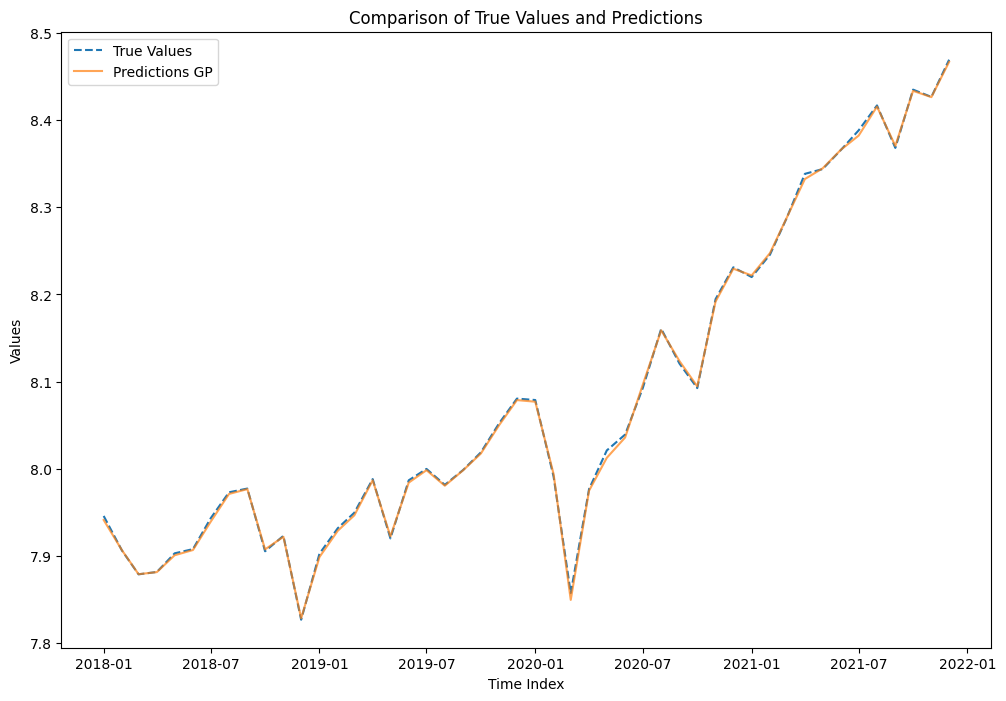

In [43]:
# Evaluation of Results
df_logindex_res = pd.DataFrame(
    {'true': test_data['logindex'], 'pred_gp': pred_gp['logindex']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logindex_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logindex_res['date'] = pd.to_datetime(df_logindex_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logindex_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logindex_res['true'], label='True Values', linestyle='--')
plt.plot(df_logindex_res['pred_gp'], label='Predictions GP', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

#### Logret (Returns) Plot

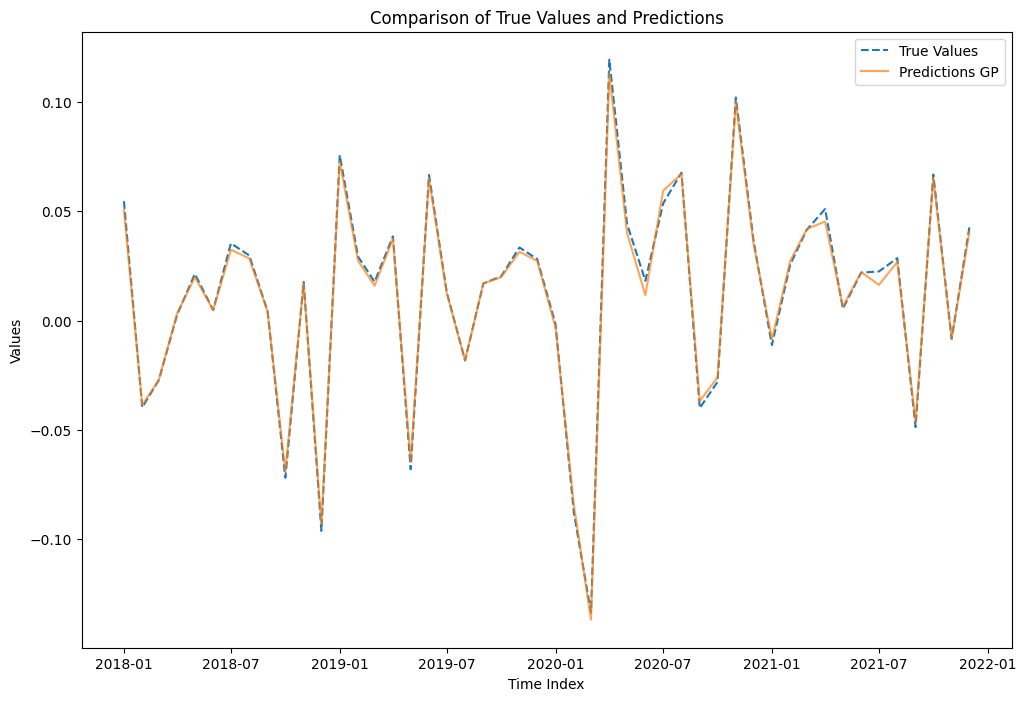

In [44]:
# Evaluation of Results
df_logret_res = pd.DataFrame(
    {'true': test_data['logret'], 'pred_gp': pred_gp['logret']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logret_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logret_res['date'] = pd.to_datetime(df_logret_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logret_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logret_res['true'], label='True Values', linestyle='--')
plt.plot(df_logret_res['pred_gp'], label='Predictions GP', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()


### Model 3: ARMA Model
Before we fit an ARMA model, we first check to see if the series is stationary

In [ ]:
#function to test if the time series is stationary using the Augmented Dickey–Fuller test
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] > 0.05:
      print("Data is not stationary")
    else:
      print("Data is stationary")

In [ ]:
targets = ['logindex', 'logret', 'direction']
for target in targets:
  test_stationarity(sp500_df_filtered[target])

ADF Statistic: 0.6551436672311208
p-value: 0.9888988290720038
Critical Values:
	1%: -3.436150192101723
	5%: -2.8641011312034057
	10%: -2.5681336157882373
Data is not stationary
ADF Statistic: -8.092508431685243
p-value: 1.3662615637880084e-12
Critical Values:
	1%: -3.4361450520165464
	5%: -2.8640988637413893
	10%: -2.5681324081722314
Data is stationary
ADF Statistic: -12.79841838220568
p-value: 6.83650539998581e-24
Critical Values:
	1%: -3.436064032324827
	5%: -2.864063122757945
	10%: -2.5681133731450605
Data is stationary


If the ADF statistic is more negative than these critical values, the null hypothesis can be rejected with the corresponding confidence level. In our case, the ADF statistic of 4.360936254804394 is not more negative than any of the critical values, confirming that the time series can be considered to have a unit root and is non-stationary at the 1%, 5%, and 10% levels.

Index is not stationary, logret and direction are stationary

Since index is not stationary, we will use differencing to stabalize them

In [ ]:
logindex_df['difflogindex'] = logindex_df['logindex'].diff()
logindex_df.dropna(inplace=True)

test_stationarity(logindex_df['difflogindex'])

ADF Statistic: -8.09135011871243
p-value: 1.3755641693941708e-12
Critical Values:
	1%: -3.436150192101723
	5%: -2.8641011312034057
	10%: -2.5681336157882373
Data is stationary


<ipython-input-41-bb34d725f743>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logindex_df['difflogindex'] = logindex_df['logindex'].diff()
<ipython-input-41-bb34d725f743>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logindex_df.dropna(inplace=True)


Now we use the auto_arima function from the pmdarima library to determine the best parameters for an ARIMA model

In [ ]:
#function to find the best parameters for the arma model, generate predictons and calculate metrics
def train_evaluate_arima(df, start_date, end_date, target):
    train = df[df['date'] < start_date]
    test = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    y_train = train[['date', target]]
    y_test = test[['date', target]]

    y_train.set_index('date', inplace=True)
    y_test.set_index('date', inplace=True)

    model = auto_arima(y_train, seasonal=True, error_action='ignore', suppress_warnings=True, stepwise=True, trace=True)
    pred_arma = model.predict(n_periods=len(y_test)) #predict

    # Align predictions with the test index dates for comparison and metrics calculation
    y_test['pred_arma'] = pred_arma

    # Calculate performance metrics
    mse = mean_squared_error(y_test[target], y_test['pred_arma'])
    mae = mean_absolute_error(y_test[target], y_test['pred_arma'])
    r2 = r2_score(y_test[target], y_test['pred_arma'])

    # Print performance metrics
    performance_metrics_arma = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    print(f"Performance metrics:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")

    return model, performance_metrics_arma, y_test

In [ ]:
#run for logindexdiff
model_index, metrics_index, index_predictions = train_evaluate_arima(logindex_df, '2018-01-01', '2021-12-31', 'difflogindex')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3281.494, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3262.219, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3267.232, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3267.479, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3255.443, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3264.346, Time=1.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3265.257, Time=0.88 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3276.556, Time=1.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3280.234, Time=1.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3265.491, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3270.560, Time=1.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3269.755, Time=1.28 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-3277.542, Time=1.51 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3275.672, Time=0.65 sec

Best model:  ARIMA

<ipython-input-42-416250510282>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred_arma'] = pred_arma


Convert the values back to original scale so i can compare with other model's results

In [ ]:
# Step 1: Get the last actual known value from the original data
last_known_value = logindex_df['logindex'].iloc[-len(index_predictions['pred_arma'])-1]

# Step 2: Cumulatively sum the predictions and add the last known value
restored_predictions = index_predictions['pred_arma'].cumsum() + last_known_value

# Optional Step 3: Append the last known value to the beginning if needed for alignment
restored_predictions = pd.concat([pd.Series([last_known_value], index=[logindex_df.index[-len(index_predictions)-1]]), restored_predictions])


In [ ]:
# Dropping the first row of the series
restored_predictions = restored_predictions[1:]
restored_predictions

2018-01-01    7.833524
2018-02-01    7.840779
2018-03-01    7.843311
2018-04-01    7.847308
2018-05-01    7.854270
2018-06-01    7.858974
2018-07-01    7.862340
2018-08-01    7.867921
2018-09-01    7.873638
2018-10-01    7.877642
2018-11-01    7.882215
2018-12-01    7.887849
2019-01-01    7.892641
2019-02-01    7.896967
2019-03-01    7.902107
2019-04-01    7.907277
2019-05-01    7.911826
2019-06-01    7.916595
2019-07-01    7.921744
2019-08-01    7.926578
2019-09-01    7.931252
2019-10-01    7.936224
2019-11-01    7.941200
2019-12-01    7.945950
2020-01-01    7.950786
2020-02-01    7.955757
2020-03-01    7.960612
2020-04-01    7.965411
2020-05-01    7.970318
2020-06-01    7.975225
2020-07-01    7.980051
2020-08-01    7.984909
2020-09-01    7.989816
2020-10-01    7.994679
2020-11-01    7.999523
2020-12-01    8.004406
2021-01-01    8.009289
2021-02-01    8.014142
2021-03-01    8.019008
2021-04-01    8.023891
2021-05-01    8.028757
2021-06-01    8.033617
2021-07-01    8.038492
2021-08-01 

In [ ]:
#run for logret
model_logret, metrics_logret, logret_predictions = train_evaluate_arima(logret_df, '2018-01-01', '2021-12-31', 'logret')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3284.885, Time=1.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3265.986, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3270.941, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3271.186, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3259.280, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3268.065, Time=1.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3267.565, Time=0.55 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3283.878, Time=1.80 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3283.989, Time=1.83 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3269.201, Time=0.82 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3274.278, Time=1.59 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3273.472, Time=1.18 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-3281.269, Time=1.74 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3279.460, Time=0.66 sec

Best model:  ARIMA

In [ ]:
restored_predictions

,date,0
0,2018-01-01,7.833524
1,2018-02-01,7.840779
2,2018-03-01,7.843311
3,2018-04-01,7.847308
4,2018-05-01,7.854270
5,2018-06-01,7.858974
6,2018-07-01,7.862340
7,2018-08-01,7.867921
8,2018-09-01,7.873638
9,2018-10-01,7.877642


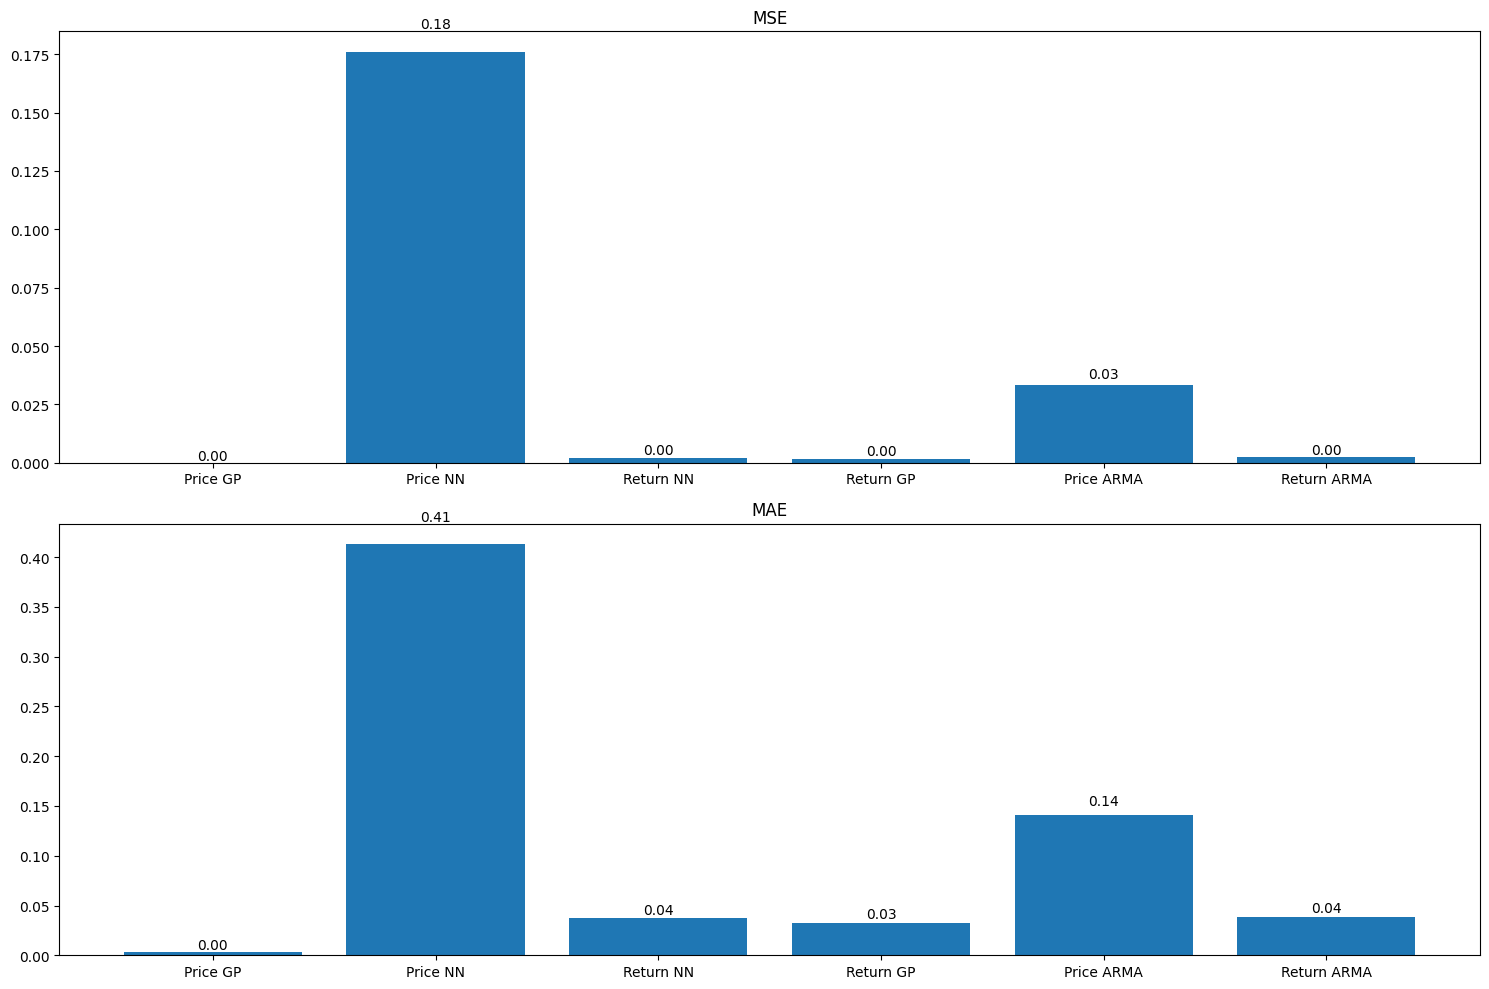

In [ ]:
#craeting a new df with the true values for logindex
logindex_df_test = logindex_df[(logindex_df['date'] >= '2018-01-01') & (logindex_df['date'] <= '2021-12-31')]
metrics_val.run(logindex_df_test['logindex'], restored_predictions[0], "Price ARMA")
metrics_val.run(logret_predictions['logret'], logret_predictions['pred_arma'], "Return ARMA")
metrics_val.plot()

In [ ]:
# Convert 'date' in test_data
test_data['date'] = pd.to_datetime(test_data['date'])
logret_predictions = logret_predictions.reset_index().rename(columns={'index': 'date'})
logret_predictions['date'] = pd.to_datetime(logret_predictions['date'])  # Adjust 'unit' as necessary

### Plots results

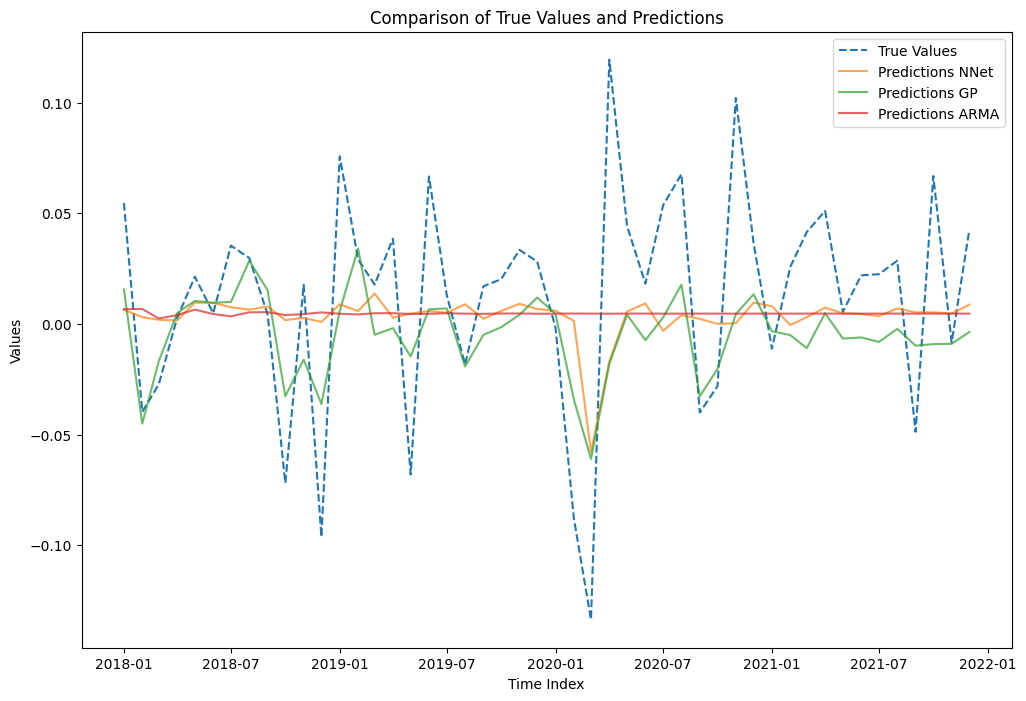

In [ ]:
#Compare ARMA model to NN and Gaussian Process Regression
# Evaluation of Results
df_logret_res = pd.DataFrame(
    {'true': test_data['logret'], 'pred_nn': test_data['logret_nn_pred'], 'pred_gp': test_data['logret_gp_pred'], 'pred_arma': logret_predictions['pred_arma']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logret_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logret_res['date'] = pd.to_datetime(df_logret_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logret_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logret_res['true'], label='True Values', linestyle='--')
plt.plot(df_logret_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logret_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logret_res['pred_arma'], label='Predictions ARMA', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

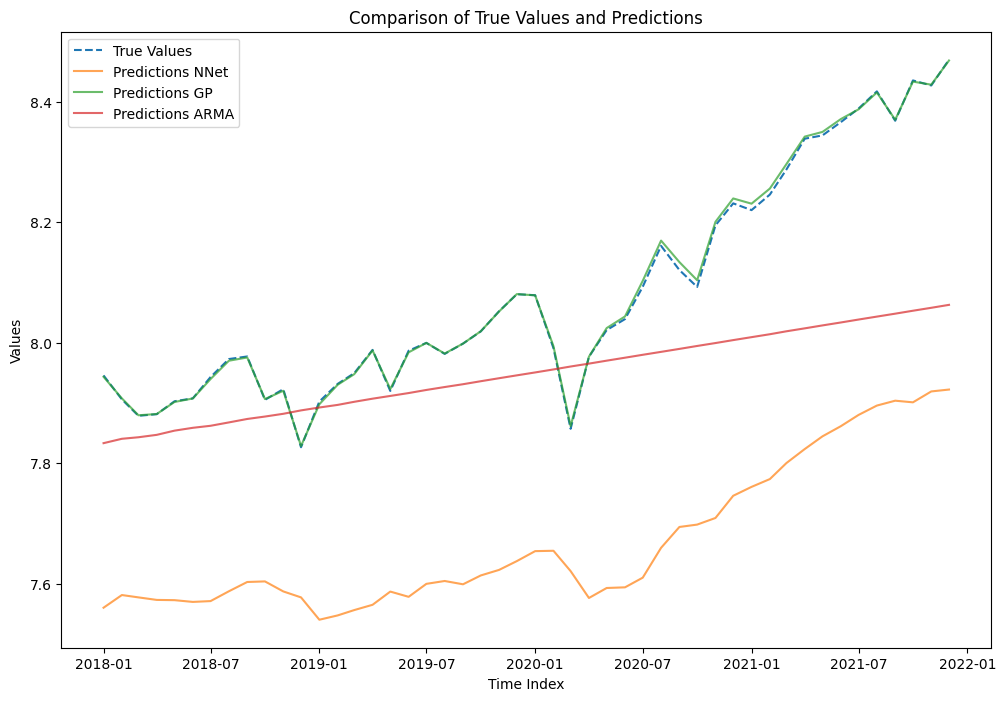

In [ ]:
# Convert 'date' in test_data
#test_data['date'] = pd.to_datetime(test_data['date'])
restored_predictions = restored_predictions.reset_index().rename(columns={'index': 'date'})
restored_predictions['date'] = pd.to_datetime(restored_predictions['date'])  # Adjust 'unit' as necessary

# Evaluation of Results
df_logindex_res = pd.DataFrame(
    {'true': test_data['logindex'], 'pred_nn': test_data['logindex_nn_pred'], 'pred_gp': test_data['logindex_gp_pred'], 'pred_arma': restored_predictions[0]}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logindex_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logindex_res['date'] = pd.to_datetime(df_logindex_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logindex_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logindex_res['true'], label='True Values', linestyle='--')
plt.plot(df_logindex_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logindex_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logindex_res['pred_arma'], label='Predictions ARMA', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()